#### Intro to DL & OOD

Resources:
- LeCun, Y., Bengio, Y. and Hinton, G., 2015. [Deep Learning](https://www.nature.com/articles/nature14539). nature, 521(7553), pp.436-444.
- [Ignite](https://pytorch-ignite.ai/)
- [PyTorch tutorials](https://pytorch.org/tutorials/) 

![MarineGEO circle logo](./figs/pytorch-cheat.jpeg "pytorch cheatsheet")

Figure from [pytorch forum](https://discuss.pytorch.org/t/pytorch-cheat-sheet/72016)

#### We need to organize our files to be easy to use by data loader classes

In [ ]:
import pandas as pd

groundtruth = pd.read_csv("../data/ISIC2019/ISIC_2019_Training_GroundTruth.csv")
groundtruth = groundtruth.set_index("image")
oodist = list(groundtruth.index[groundtruth.DF == 1])
indist = list(groundtruth.index[groundtruth.NV == 1])

In [ ]:
from pathlib import Path
import shutil

# get the path/directory
folder_dir = "../data/ISIC2019/ISIC_2019_Training_Input/"
dest_ind_dir = "../data/isic_torch/0"
dest_outd_dir = "../data/isic_torch/1"
images = Path(folder_dir).glob("*.jpg")

for i in images:
    if i.stem in indist:
        shutil.copy(i, dest_ind_dir)
    elif i.stem in oodist:
        shutil.copy(i, dest_outd_dir)

#### How to create a simple autoencoder?

In [1]:
import torch
from ae import Autoencoder
from torchsummary import summary

ae = Autoencoder()

if torch.cuda.is_available():
    ae = ae.cuda()
summary(ae, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 16, 16]             588
              ReLU-2           [-1, 12, 16, 16]               0
            Conv2d-3             [-1, 24, 8, 8]           4,632
              ReLU-4             [-1, 24, 8, 8]               0
            Conv2d-5             [-1, 48, 4, 4]          18,480
              ReLU-6             [-1, 48, 4, 4]               0
   ConvTranspose2d-7             [-1, 24, 8, 8]          18,456
              ReLU-8             [-1, 24, 8, 8]               0
   ConvTranspose2d-9           [-1, 12, 16, 16]           4,620
             ReLU-10           [-1, 12, 16, 16]               0
  ConvTranspose2d-11            [-1, 3, 32, 32]             579
          Sigmoid-12            [-1, 3, 32, 32]               0
Total params: 47,355
Trainable params: 47,355
Non-trainable params: 0
---------------------------------

#### How to make the images ready for our Autoencoder?
- Dataset classes (e.g ImageFolder)
- Dataloader (How to iterate our dataset with DataLoader)
- Transformations (Preprocessing functions and augmentation techniques)

In [2]:
from torchvision import transforms as tfs

transforms_train = [tfs.RandomHorizontalFlip(p=0.7),
           tfs.RandomAffine(0, scale=(0.7, 1.)),
           tfs.Resize((32, 32)),
           #tfs.Grayscale(1),
           tfs.ToTensor()]
           #tfs.Normalize((0.5,), (0.5,), (0.5,))]

transforms_test = [
           tfs.RandomAffine(0, scale=(0.7, 1.)),
           tfs.Resize((32, 32)),
           #tfs.Grayscale(1),
           tfs.ToTensor()]
           #tfs.Normalize((0.5,), (0.5,), (0.5,))]

In [3]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

image_data_train = ImageFolder('../data/isic_torch/train/',
                            transform=tfs.Compose(transforms_train))
image_data_test = ImageFolder('../data/isic_torch/test/',
                            transform=tfs.Compose(transforms_test))

In [5]:
data_loader_train = DataLoader(image_data_train, batch_size=30, shuffle=True)
data_loader_test = DataLoader(image_data_test, batch_size=30, shuffle=True)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])


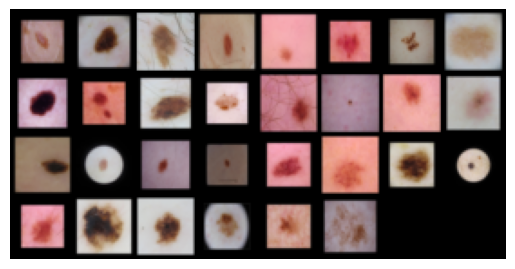

In [6]:
from aux import create_plot_window, imshow
import torchvision

dataiter = iter(data_loader_train)
images, labels = next(dataiter)
print(labels)
imshow(torchvision.utils.make_grid(images))

tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])


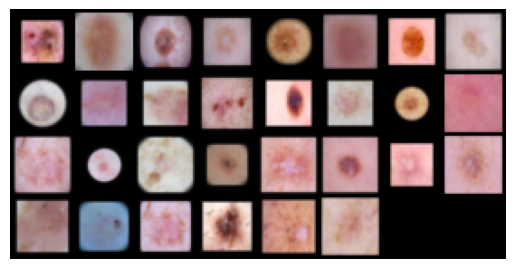

In [7]:
dataiter = iter(data_loader_test)
images, labels = next(dataiter)
print(labels)
imshow(torchvision.utils.make_grid(images))

#### After our data is loaded into PyTorch we will use ignite to train our model
    - We need to define which criterion to use during trainig.
    - How to optimize our solution space.
    - Define which metrics to we want to follow during training.

In [10]:
import torch.nn.functional as F
from torch import nn
import torch.optim as optim

device = 'cpu'

ae = Autoencoder()
criterion = nn.BCELoss()
optimizer = optim.Adam(ae.parameters(), lr=0.0002, betas=(0.5, 0.999))

if torch.cuda.is_available():
    AE = ae.cuda()
    criterion.cuda()
    

In [14]:
from aux import get_torch_vars
epochs = 1

for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, _) in enumerate(data_loader_train, 0):
            inputs = get_torch_vars(inputs)

            # Forward Pass
            encoded, outputs = ae(inputs)
            loss = criterion(outputs, inputs)
            
            # Backward Pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.data
            if i % 10 == 0:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / epochs))
                running_loss = 0.0

[1,     1] loss: 0.509
[1,    11] loss: 5.005
[1,    21] loss: 4.949
[1,    31] loss: 4.797


KeyboardInterrupt: 